In [14]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math as math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

# fix random seed for reproducibility
seed = 7
#np.random.seed(seed)
print "Hello world!"

Hello world!


In [33]:
szr_load = np.loadtxt('pre_szr.csv', delimiter=',') #load positive samples
non_szr_load = np.loadtxt('non_szr.csv', delimiter=',') #load negative samples

In [34]:
NUM_CYCLES = 2 #set how many k-fold iterations over the dataset we'll fit
NUM_EPOCHS = 15
BATCH_SIZE = 100
TEST_SET = .2

In [35]:
def split_data(data, mask):
    res = []
    tempres = []
    for index, x in enumerate(data):
        if index > len(mask) - 1:
            break #avoid accessing out of bounds
        if mask[index] > 0:
            tempres = []
            res.append(tempres) #add temp array into result array
        tempres.append(x[:23]) #add first 23 features to temp array
    
    data = np.asarray(res) #szr now contains 50 different pre-seizure events
    return data

def chunk_data(pos, neg):
    X_train = np.array([], dtype=int).reshape(-1,23)
    Y_train = []
    X_test = np.empty((0, 23))
    Y_test = []
    for index, i in enumerate(szr):
        #create training set out of first % of samples
        if index < int(len(szr) * (1 - TEST_SET)):
            X_train = np.vstack((X_train, i))
            Y_train = np.append(Y_train, np.ones(len(i)))
            # we end up with an array of shape:
            # positive data
            # negative data
            # positive data
            # negative data
            X_train = np.vstack((X_train, non_szr[index]))
            Y_train = np.append(Y_train, np.zeros(len(non_szr[index])))
        else:
            X_test = np.vstack((X_test, i))
            Y_test = np.append(Y_test, np.ones(len(i)))
            X_test = np.vstack((X_test, non_szr[index]))
            Y_test = np.append(Y_test, np.zeros(len(non_szr[index])))
    return X_train, Y_train, X_test, Y_test

In [36]:
#generate mask that identifies when labels change
mask = np.diff(szr_load[:,23])
mask = np.hstack((1, mask))
szr = split_data(szr_load, mask)
non_szr = split_data(non_szr_load, mask)

np.random.shuffle(szr) #only shuffled on first axis, so data stays intact temporally
np.random.shuffle(non_szr)

X_train, Y_train, X_test, Y_test = chunk_data(szr, non_szr)
        
Y_test = np.asarray(Y_test)
Y_train = np.asarray(Y_train)
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape
#data = np.vstack((non_szr[num_chunks - 1], szr)) #stacks the last full chunk of negative data on the positive data
#labels = np.hstack((np.zeros(len(non_szr[num_chunks - 1])), np.ones(len(szr)))) #generates labels corresponding
#to the data

#X_throwaway, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=.2) #gives us test chunks
#print Y_test.shape

(51120, 23)
(12780, 23)
(51120,)
(12780,)


In [37]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=23, init='normal', activation='sigmoid'))
model.add(Dense(10, init='normal', activation='sigmoid'))
model.add(Dense(1, init='uniform', activation='sigmoid')) #last layer needs to be sigmoid activation (why?)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, nb_epoch=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
51120/51120 [==============================] - 2s - loss: 0.6930 - acc: 0.5048     
Epoch 2/15
51120/51120 [==============================] - 1s - loss: 0.6670 - acc: 0.6223     
Epoch 3/15
51120/51120 [==============================] - 1s - loss: 0.4206 - acc: 0.8541     
Epoch 4/15
51120/51120 [==============================] - 1s - loss: 0.3071 - acc: 0.8858     
Epoch 5/15
51120/51120 [==============================] - 1s - loss: 0.2813 - acc: 0.8942     
Epoch 6/15
51120/51120 [==============================] - 1s - loss: 0.2702 - acc: 0.8980     
Epoch 7/15
51120/51120 [==============================] - 1s - loss: 0.2645 - acc: 0.9006     
Epoch 8/15
51120/51120 [==============================] - 1s - loss: 0.2607 - acc: 0.9024     
Epoch 9/15
51120/51120 [==============================] - 1s - loss: 0.2571 - acc: 0.9034     
Epoch 10/15
51120/51120 [==============================] - 1s - loss: 0.2561 - acc: 0.9038     
Epoch 11/15
51120/51120 [========================

In [38]:
# evaluate the model
scores = model.evaluate(X_train, Y_train)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#generate prediction probabilities for ROC curve
proba = model.predict_proba(X_test, verbose=1)

10752/12780 [========================>.....] - ETA: 0s

In [39]:
def generate_results(predictions, actual):
    #This just plots the ROC curve
    false_positive_rate, true_positive_rate, thresholds = met.roc_curve(actual, predictions)
    roc_auc = met.auc(false_positive_rate, true_positive_rate)
    
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

0.951398078962


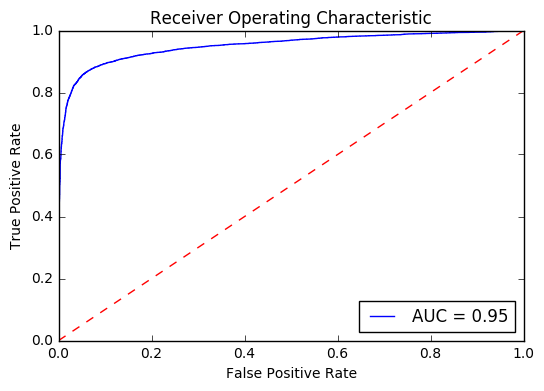

In [40]:
import sklearn.metrics as met

print met.roc_auc_score(Y_test, proba)
generate_results(proba, Y_test)

In [81]:
#model.save('prediction.h5')
#model.save_weights('prediction_weights.h5')